In [104]:
import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import Bidirectional, TimeDistributed, GRU
from keras.layers import LSTM, Input, Reshape, Concatenate, Flatten,Convolution1D
from keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling1D, MaxPool2D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

{'political': 2, 'misc': 1, 'violence/terrorism': 0}
0       0
1       1
2       1
3       1
4       0
5       1
6       1
7       1
8       2
9       1
10      1
11      2
12      2
13      1
14      0
15      2
16      1
17      1
18      1
19      2
20      2
21      0
22      0
23      1
24      0
25      1
26      2
27      0
28      1
29      1
       ..
1516    1
1517    0
1518    2
1519    1
1520    2
1521    2
1522    2
1523    2
1524    1
1525    1
1526    2
1527    0
1528    0
1529    2
1530    0
1531    0
1532    0
1533    0
1534    0
1535    0
1536    0
1537    1
1538    0
1539    1
1540    2
1541    1
1542    2
1543    2
1544    1
1545    0
Name: target, Length: 1449, dtype: int64


0    syrian assad say syria killed damascus people ...
1    use osc copyrighted_material dissemination usa...
2    will year can people one country party make sa...
3    quot apos say the we it reuters terrorists ass...
4    baghdad iraq sunni killed bomb iraqi attacks w...
Name: topicFlat, dtype: object

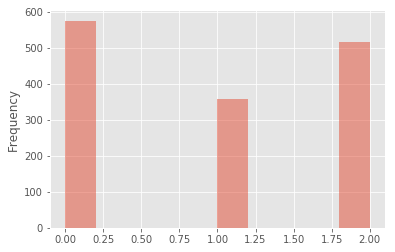

In [141]:
data_train = pd.read_csv('result_all_windows_labels.csv')

# Cleanup - remove no labels
data_train = data_train[data_train['label'].notnull()]
data_train = data_train[data_train.label != 'environmental']
data_train = data_train[data_train.label != 'religious']
data_train = data_train[data_train.label != 'economical']


label_cat = {'violence/terrorism' : 0, 'misc': 1, 'political': 2, 
#              'religious': 4, 'economical': 5, 'environmental': 6
            }
print(label_cat) 


def to_category(x):
    return label_cat[x]

data_train['target'] = data_train.apply(lambda row: to_category(row['label']), axis=1)


data_train['target'].plot.hist(alpha=0.5)


texts = []
# Get corpus by joining all keywords
for index, row in data_train.iloc[ :, 2:32].iterrows():
    texts.append(u' '.join(row.tolist()))
    
data_train['topicFlat'] = texts

# texts = datdata_traina_train['topicFlat']
labels = data_train['target']

print(labels)
data_train['topicFlat'].head()


In [3]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Emedding

In [126]:
max_words = 10000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 100 


print('Loading data...')
# (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
#                                                          test_split=0.2)

# X = data_train['topicFlat'].values
Y = pd.get_dummies(data_train['label']).values
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_train['topicFlat'].values)
X = tokenizer.texts_to_sequences(data_train['topicFlat'].values)
print(X[0])


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


# Define the max seq length based on mar
# MAX_SEQUENCE_LENGTH = len(word_index)


X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
# print(X[0])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state = 4)

print(y_train[100])
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = y_train.shape[1]
print(num_classes, 'classes')

# print('Vectorizing sequence data...')
# x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
# x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Converted class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Loading data...
[4, 17, 1, 2, 16, 42, 7, 47, 178, 56, 30, 1014, 395, 8, 160, 22, 38, 12, 201, 3300, 142, 10, 3, 17, 1640, 202, 433, 396, 307, 82, 145, 649]
Found 6077 unique tokens.
[0 1 0]
(1159, 500) (1159, 3)
(290, 500) (290, 3)
1159 train sequences
290 test sequences
3 classes
x_train shape: (1159, 500)
x_test shape: (290, 500)
Converted class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1159, 3)
y_test shape: (290, 3)


In [127]:
embeddings_index = {}
f = open( 'data/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [128]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
#
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_66 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_108 (Dense)            (None, 3)                 603       
Total params: 769,203
Trainable params: 769,203
Non-trainable params: 0
_________________________________________________________________
Train on 1159 samples, validate on 290 samples
Epoch 1/10
1159/1159 [==============================] - 129s 111ms/step - loss: 0.5228 - acc: 0.7972 - val_loss: 0.5065 - val_acc: 0.8000
Epoch 2/10
1159/1159 [==========================

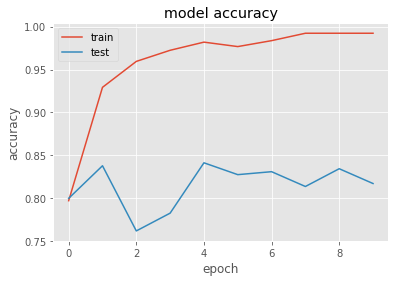

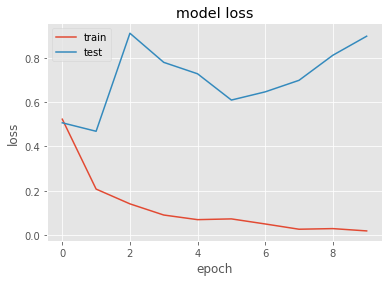

In [124]:

# https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-RNN/
# 81%
epochs=10
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(num_classes, activation='softmax')(l_lstm)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Bidirectional LSTM")
model.summary()
network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)


score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

In [121]:

# Hierachical LSTM
# https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py

MAX_SENTS = 30
sentence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS, MAX_SEQUENCE_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(2, activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Hierachical LSTM")
print (model.summary())

network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)


score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)


model fitting - Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 30, 500)           0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 30, 200)           768600    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_105 (Dense)            (None, 2)                 402       
Total params: 1,009,802
Trainable params: 1,009,802
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Error when checking input: expected input_52 to have 3 dimensions, but got array with shape (1159, 500)

In [118]:

# https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py

from keras.engine.topology import Layer, InputSpec
from keras import initializers
from keras import backend as K

# building Hierachical Attention network - 2nd part
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        #self.input_spec = [InputSpec(ndim=3)]
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        #self.W = self.init((input_shape[-1],1))
        self.W = self.init((input_shape[-1],))
        #self.input_spec = [InputSpec(shape=input_shape)]
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x, self.W))
        
        ai = K.exp(eij)
        weights = ai/K.sum(ai, axis=1).dimshuffle(0,'x')
        
        weighted_input = x*weights.dimshuffle(0,1,'x')
        return weighted_input.sum(axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


sentence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_dense = TimeDistributed(Dense(200))(l_lstm)
l_att = AttLayer()(l_dense)
sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(MAX_SENTS, MAX_SEQUENCE_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
l_dense_sent = TimeDistributed(Dense(200))(l_lstm_sent)
l_att_sent = AttLayer()(l_dense_sent)
preds = Dense(2, activation='softmax')(l_att_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

print("model fitting - Hierachical attention network")

network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 30, 500)           0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 200)           768800    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 30, 200)           180600    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 30, 200)           40200     
_________________________________________________________________
att_layer_12 (AttLayer)      (None, 200)               200       
_________________________________________________________________
dense_102 (Dense)            (None, 2)                 402       
Total params: 990,202
Trainable params: 990,202
Non-trainable params: 0
_________________________________________________________________
None

ValueError: Error when checking input: expected input_48 to have 3 dimensions, but got array with shape (1159, 500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 496, 64)           32064     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 99, 64)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 95, 64)            20544     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 19, 64)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 15, 64)            20544     
__________

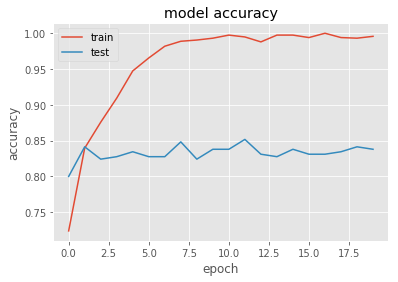

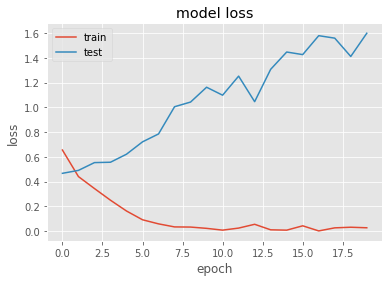

In [58]:
%%time

# Very hopefull... work on this
# https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
epochs=20

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())


network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 500, 64)           19264     
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 500, 32)           6176      
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 500, 16)           1552      
_________________________________________________________________
flatten_7 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 8000)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 180)               1440180   
__________

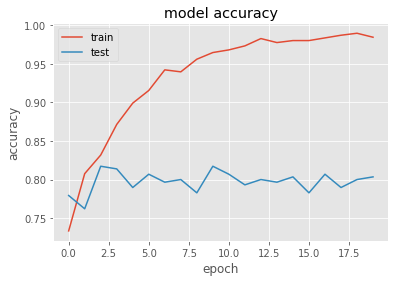

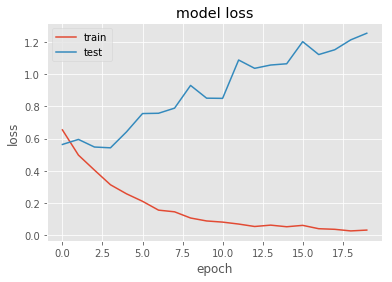

CPU times: user 8min 37s, sys: 9min 10s, total: 17min 47s
Wall time: 5min


In [69]:
%%time

# https://github.com/Theo-/sentiment-analysis-keras-conv/blob/master/train_keras.py
model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

# Convolutional model (3x conv, flatten, 2x dense)
model.add(Convolution1D(64, 3, padding='same'))
model.add(Convolution1D(32, 3, padding='same'))
model.add(Convolution1D(16, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(180, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())


network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               128128    
_________________________________________________________________
activation_14 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_15 (Activation)   (None, 3)                 0         
Total params: 128,515
Trainable params: 128,515
Non-trainable params: 0
_________________________________________________________________
None
Train on 1159 samples, validate on 290 samples
Epoch 1/50
1159/1159 [==============================] - 1s 467us/s

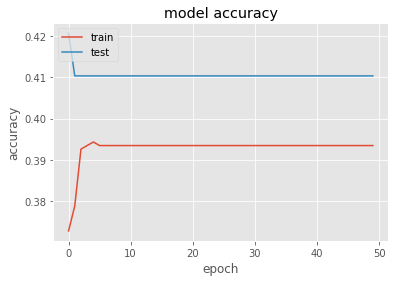

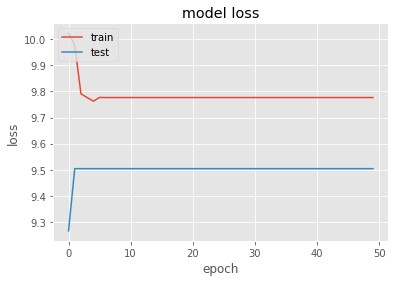

CPU times: user 38.4 s, sys: 55.9 s, total: 1min 34s
Wall time: 31.2 s


In [45]:
%%time

# not learning anything
# doesnt get better than random guess

batch_size = 10
epochs = 30

print('Building model...')
model = Sequential()


model.add(Dense(128, input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)


print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

Build LSTM model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_109 (Dense)            (None, 3)                 195       
Total params: 650,235
Trainable params: 42,435
Non-trainable params: 607,800
_________________________________________________________________
None
Train...
Train on 1159 samples, validate on 290 samples
Epoch 1/5
1159/1159 [==============================] - 137s 118ms/step - loss: 0.8352 - acc: 0.6471 - val_loss: 0.6160 - val_acc: 0.7621
Epoch 2/5
1159/1159 [==============================] - 136s 117ms/step - loss: 0.5929 - acc: 0.7748 - val_loss: 0.8153 - val_acc: 0.6483
Epoch 3/5
1159/1159 [===================

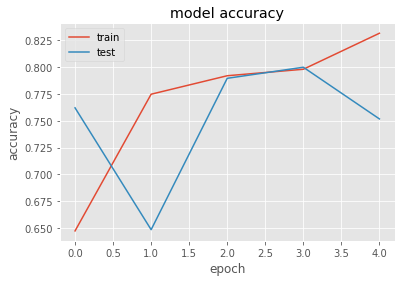

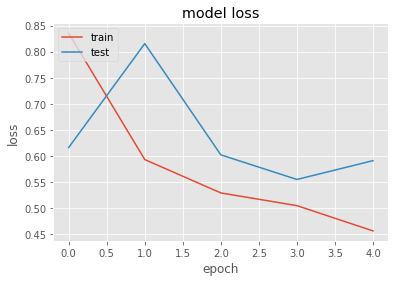

CPU times: user 10min 54s, sys: 1min 5s, total: 12min
Wall time: 11min 59s


In [125]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

epochs = 5

print('Build LSTM model...')
model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print(model.summary())

print('Train...')
network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=epochs,
                         verbose=1, validation_data=(x_test, y_test),
                         validation_split=0.2)


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 1000, 100)         607800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1000, 100)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 998, 64)           19264     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
activation_20 (Activation)   (None, 128)               0     

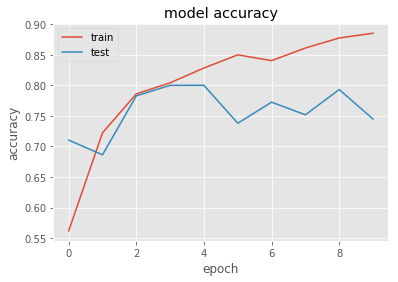

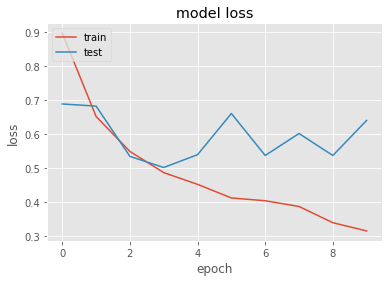

CPU times: user 4min 11s, sys: 3min 55s, total: 8min 7s
Wall time: 2min 21s


In [50]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py

# set parameters:
batch_size = 32
embedding_dims = 100
filters = 64
kernel_size = 3
hidden_dims = 64
epochs = 10


print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(len(word_index) + 1, 
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print(model.summary())


print('Training...')
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, validation_split=0.2,
          validation_data=(x_test, y_test))


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

In [52]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 10
epochs = 10

print('Build model...')

model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

model.add(Dropout(0.2))

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print(model.summary())

print('Train...')
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, validation_split=0.2,
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 1000, 100)         607800    
_________________________________________________________________
dropout_23 (Dropout)         (None, 1000, 100)         0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 996, 64)           32064     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 249, 64)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 213       
_________________________________________________________________
activation_23 (Activation)   (None, 3)                 0     

KeyboardInterrupt: 

In [70]:
%%time

# https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py

vocabulary_size = len(word_index) # 18765
# embedding_dim = 100
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 20
batch_size = 30

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(len(word_index) + 1,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False)(inputs)
# Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)

reshape = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), 
                padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), 
                padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=num_classes, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

print("Traning Model...")
network_hist = model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, callbacks=[checkpoint], 
          validation_data=(x_test, y_test))  # starts training


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)


Creating Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 500, 100)     607800      input_15[0][0]                   
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 500, 100, 1)  0           embedding_33[0][0]               
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 498, 1, 512)  154112      reshape_2[0][0]                  
___________________________________________________________________________________________

KeyboardInterrupt: 

In [71]:
# Keras convolutional model
batch_size = 32
epochs = 20


model = Sequential()
model.add(Embedding(len(word_index) + 1,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

# model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))


model.add(Dense(units=num_classes, activation='softmax'))

adam = Adam(lr=0.0001, decay=1e-6)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print(model.summary())

print('Training...')
# Fit the model
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)])


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 500, 32)           9632      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 500, 32)           3104      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 500, 32)           3104      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 500, 32)           3104      
_________________________________________________________________
dropout_33 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 500, 32)           2080      
__________

KeyboardInterrupt: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_84 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
flatten_44 (Flatten)         (None, 50000)             0         
_________________________________________________________________
dense_125 (Dense)            (None, 3)                 150003    
Total params: 757,803
Trainable params: 150,003
Non-trainable params: 607,800
_________________________________________________________________
None
Training...
Train on 1159 samples, validate on 290 samples
Epoch 1/10
1159/1159 [==============================] - 0s 363us/step - loss: 1.0162 - acc: 0.4944 - val_loss: 0.9744 - val_acc: 0.5241
Epoch 2/10
1159/1159 [==============================] - 0s 395us/step - loss: 0.8829 - acc: 0.6376 - val_loss: 0.8568 - val_acc: 0.6931
Epoch 3/10
1159/1159 [==============================] - 0s

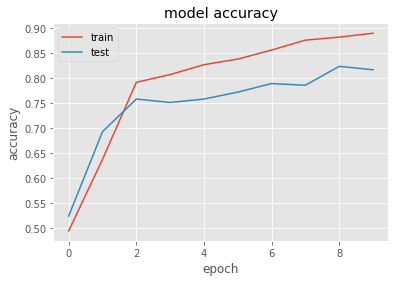

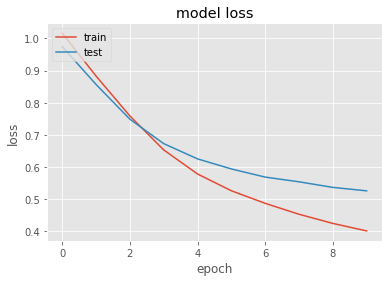

[[73  5 11]
 [ 0 79 16]
 [ 4 17 85]]
CPU times: user 5.82 s, sys: 564 ms, total: 6.38 s
Wall time: 5.65 s


In [146]:
%%time

# simple 83%
epochs = 10
# define model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

# 128 = 83%, 64 = 827%,  256 = 83.1%
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# 


model.add(Flatten())
model.add(Dense(num_classes, activation='sigmoid'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(optimizer=adam, 
              loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

print('Training...')
# Fit the model
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test, y_test))


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)


y_pred = model.predict(x_test)
# print(y_pred[:10])
# print(y_test[:10])
from sklearn.metrics import confusion_matrix

class_labels = np.argmax(y_test, axis=1) 
# print(class_labels[:10])
# print(y_pred.argmax(axis=1))
print(confusion_matrix(class_labels, 
                       y_pred.argmax(axis=1)))

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_66 (Embedding)     (None, 500, 100)          607800    
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_104 (Dense)            (None, 3)                 603       
Total params: 769,203
Trainable params: 769,203
Non-trainable params: 0
_________________________________________________________________
Train on 1159 samples, validate on 290 samples
Epoch 1/30
1159/1159 [==============================] - 105s 91ms/step - loss: 0.7601 - acc: 0.6497 - val_loss: 0.6852 - val_acc: 0.7414
Epoch 2/30
1159/1159 [===========================

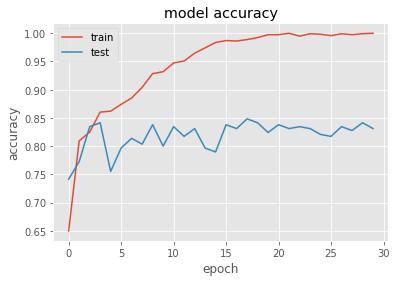

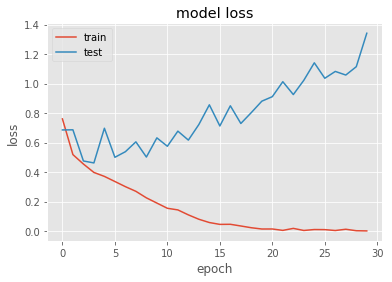

In [120]:

# https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-RNN/
# 83%
epochs = 20
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)

preds = Dense(num_classes, activation='softmax')(l_lstm)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Bidirectional LSTM")
model.summary()

network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)